#WGAN (2D)
---

<font size = 4>**Wasserstein Generative Adversarial Network** (WGAN) is an alternative to traditional GAN training, it was published by [Arjovsky, Martin and Chintala, Soumith and Bottou, Leon](http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf). This network aims to recover a high-resolution (HR) image from a low-resolution (LR) image and in order to achieve it, a new loss function is proposed: Wasserstein distance or Earth Mover's Distance. They claim a better stability of learning wich is one of the main problems in GAN training.

---

<font size = 4>*Disclaimer*:

<font size = 4>This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by [Iván Hidalgo Cenalmor](https://github.com/IvanHCenalmor), [Pablo Alonso Pérez](https://www.linkedin.com/in/palonso998/?originalSubdomain=es), [Ignacio Argnada-Carreras](https://sites.google.com/site/iargandacarreras/) and [Estibaliz Gómez de Mariscal](https://github.com/esgomezm).

<font size = 4>This notebook is largely based on the paper:

<font size = 4>**Wasserstein Generative Adversarial Networks** from M. Arjovsky, S. Chintala, and L. Bottou: https://proceedings.mlr.press/v70/arjovsky17a.html

<font size = 4>**The Original code** is freely available in GitHub:
https://github.com/martinarjovsky/WassersteinGAN

<font size = 4>**Please also cite this original paper when using or developing this notebook.**

# **How to use this notebook?**

---

<font size = 4>Video describing how to use ZeroCostDL4Mic notebooks are available on youtube:
  - [**Video 1**](https://www.youtube.com/watch?v=GzD2gamVNHI&feature=youtu.be): Full run through of the workflow to obtain the notebooks and the provided test datasets as well as a common use of the notebook
  - [**Video 2**](https://www.youtube.com/watch?v=PUuQfP5SsqM&feature=youtu.be): Detailed description of the different sections of the notebook


---
###**Structure of a notebook**

<font size = 4>The notebook contains two types of cell:  

<font size = 4>**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

<font size = 4>**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appears). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Table of contents, Code snippets** and **Files**

<font size = 4>On the top left side of the notebook you find three tabs which contain from top to bottom:

<font size = 4>*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

<font size = 4>*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

<font size = 4>*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

<font size = 4>**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

<font size = 4>**Note:** The "sample data" in "Files" contains default files. Do not upload anything in here!

---
###**Making changes to the notebook**

<font size = 4>**You can make a copy** of the notebook and save it to your Google Drive. To do this click file -> save a copy in drive.

<font size = 4>To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
You can use the `#`-mark in code cells to comment out parts of the code. This allows you to keep the original code piece in the cell as a comment.

#**0. Before getting started**
---

<font size = 4>**We strongly recommend that you generate extra paired images. These images can be used to assess the quality of your trained model (Quality control dataset)**. The quality control assessment can be done directly in this notebook.

<font size = 4> **Additionally, the corresponding input and output files need to have the same name**.

<font size = 4> Please note that you currently can **only use .tif files!**


<font size = 4>Here's a common data structure that can work:
*   Experiment A
    - **Training dataset**
      - Low resolution (LR) images (Training_source)
        - img_1.tif, img_2.tif, ...
      - High resolution (HR) images (Training_target)
        - img_1.tif, img_2.tif, ...
    - **Quality control dataset**
     - Low resolution (LR) images
        - img_1.tif, img_2.tif
      - High resolution (HR) images
        - img_1.tif, img_2.tif
    - **Data to be predicted**
    - **Results**

---
<font size = 4>**Important note**

<font size = 4>- If you wish to **Train a network from scratch** using your own dataset (and we encourage everyone to do that), you will need to run **sections 1 - 4**, then use **section 5** to assess the quality of your model and **section 6** to run predictions using the model that you trained.

<font size = 4>- If you wish to **Evaluate your model** using a model previously generated and saved on your Google Drive, you will only need to run **sections 1 and 2** to set up the notebook, then use **section 5** to assess the quality of your model.

<font size = 4>- If you only wish to **run predictions** using a model previously generated and saved on your Google Drive, you will only need to run **sections 1 and 2** to set up the notebook, then use **section 6** to run the predictions on the desired model.
---

# **1. Install WGAN and dependencies**
---

In [1]:
#@markdown ##Install Network and dependencies
Notebook_version = '1.13'
Network = 'WGAN (2D)'

!pip install pytorch-lightning --quiet

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import random
import shutil
import csv
import os

from collections import defaultdict, OrderedDict
from tqdm import tqdm

import skimage
from skimage import transform
from skimage import filters
from skimage import metrics
from skimage import io
from skimage.util import random_noise
from skimage.util import img_as_ubyte
from skimage.util import img_as_uint

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.core import LightningModule
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.loggers import CSVLogger

import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorflow.image import ssim_multiscale as mssim

from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.ndimage.interpolation import zoom as npzoom
from torchvision.utils import save_image

###

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(666)

###

# Create corresponding training patches synthetically by adding noise
# and downsampling the images (see https://www.biorxiv.org/content/10.1101/740548v3)
def em_crappify(img, scale):
  img = filters.gaussian(img, sigma=3) + 1e-6
  return transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)

def fluo_crappify(img,scale):
  img = random_noise(img, mode='salt', amount=0.005)
  img = random_noise(img, mode='pepper', amount=0.005)
  img = filters.gaussian(img, sigma=5) + 1e-10
  return transform.resize(img, (img.shape[0]//scale, img.shape[1]//scale), order=1)
  
def create_complete_images( lr_path, hr_path, only_hr, 
                           type_hr_data, only_hr_path, scale):
  ''' Create a list of images patches out of a list of images
  Args:
      lr_path (string): low resolution (LR) image path (input images).
      hr_path (string): high resolution (HR) image path (ground truth images).
      only_hr (boolean): indicates if only HR images will be used.
      type_hr_data (string): in case only HR images would be used, what type of data they would be (Electron microscopy or Fluorescence).
      only_hr_path (string): in case only HR images would be used, HR image path (ground truth images).
      scale (int): scale factor between LR and HR images. Example: 2.
      num_patches (int): number of patches for each image.
      lr_shape (2D array): size of the LR patches. Example: [128, 128].
      
  Returns:
      list of image patches (LR) and patches of corresponding labels (HR)
  '''
  if only_hr:
    _, extension = os.path.splitext(os.listdir(only_hr_path)[0])
    filenames = [x for x in os.listdir( only_hr_path ) if x.endswith(extension)]
    filenames.sort()

    # read training images
    hr_img = img_as_ubyte( io.imread( only_hr_path + '/' + filenames[0] ) )

  else:
    _, extension = os.path.splitext(os.listdir(hr_path)[0])
    filenames = [x for x in os.listdir( hr_path ) if x.endswith(extension)]
    filenames.sort()

    # read training images
    hr_img = img_as_ubyte( io.imread( hr_path + '/' + filenames[0] ) )

  input_images= []
  output_images = []
  for n in range( 0, len( filenames ) ):
    if only_hr:
      hr_img = img_as_ubyte( io.imread( only_hr_path + '/' + filenames[n] ) )
      # If no path to the LR images is given, they will be artificially generated
      if type_hr_data == "Electron microscopy":
        lr_img = em_crappify(hr_img, scale)
      else:
        lr_img = fluo_crappify(hr_img, scale)
      hr_img = hr_img / 255.0
      # lr_img is not normalized because the crappify function already normalizes it
    else:
      hr_img = img_as_ubyte( io.imread( hr_path + '/' + filenames[n] ) ) / 255.0
      lr_img = img_as_ubyte( io.imread( lr_path + '/' + filenames[n] ) ) / 255.0

    input_images.append(lr_img)
    output_images.append(hr_img)
  return input_images, output_images

###

class bcolors:
  WARNING = '\033[31m'

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        hr, lr = sample['hr'], sample['lr']

        # Pytorch is (batch, channels, width, height)
        hr = hr.transpose((2, 0, 1))
        lr = lr.transpose((2, 0, 1))
        return {'hr': torch.from_numpy(hr),
                'lr': torch.from_numpy(lr)}

class RandomHorizontalFlip(object):
    """Random horizontal flip"""

    def __init__(self):
        self.rng = np.random.default_rng()

    def __call__(self, sample):
        hr, lr = sample['hr'], sample['lr']

        if self.rng.random() < 0.5:
            hr = np.flip(hr, 1)
            lr = np.flip(lr, 1)

        return {'hr': hr.copy(),
                'lr': lr.copy()}

class RandomVerticalFlip(object):
    """Random vertical flip"""

    def __init__(self):
        self.rng = np.random.default_rng()

    def __call__(self, sample):
        hr, lr = sample['hr'], sample['lr']

        if self.rng.random() < 0.5:
            hr = np.flip(hr, 0)
            lr = np.flip(lr, 0)

        return {'hr': hr.copy(),
                'lr': lr.copy()}

class RandomRotate(object):
    """Random rotation"""

    def __init__(self):
        self.rng = np.random.default_rng()

    def __call__(self, sample):
        hr, lr = sample['hr'], sample['lr']

        k = self.rng.integers(4)

        hr = np.rot90(hr, k=k)
        lr = np.rot90(lr, k=k)

        return {'hr': hr.copy(),
                'lr': lr.copy()}

class EMDataset(Dataset):
    def __init__(self, 
                 num_patches_x, 
                 num_patches_y,
                 down_factor,
                 transf=None, 
                 validation=False, 
                 validation_split=None,
                 hr_imgs_basedir="", 
                 lr_imgs_basedir="",
                 only_high_resolution_data=False,
                 only_hr_imgs_basedir="",
                 type_of_data="Electron microscopy"):
      
        if only_high_resolution_data:
          _, extension = os.path.splitext(os.listdir(only_hr_imgs_basedir)[0])

          filenames = [only_hr_imgs_basedir + '/' + x for x in os.listdir(only_hr_imgs_basedir) if x.endswith(extension)]
          filenames.sort()
        
        else:
          _, extension = os.path.splitext(os.listdir(hr_imgs_basedir)[0])

          filenames = [hr_imgs_basedir + '/' + x for x in os.listdir(hr_imgs_basedir) if x.endswith(extension)]
          filenames.sort()

        if validation_split is not None:
            val_files = int(len(filenames) * validation_split)
            if validation:
                img_names = filenames[:val_files]
            else:
                img_names = filenames[val_files:]
        else:
                img_names = filenames

        self.imgs = [img_as_ubyte(io.imread(x)) / 255.0 for x in img_names]

        if only_high_resolution_data:
            # LR images are obtained from crappifying HR images
            self.imgs_lr = [self.hr_to_lr(x, down_factor, type_of_data) for x in self.imgs]
        else:
            _, lr_extension = os.path.splitext(os.listdir(lr_imgs_basedir)[0])

            lr_filenames = [lr_imgs_basedir + '/' + x for x in os.listdir(lr_imgs_basedir) if x.endswith(lr_extension)]
            lr_filenames.sort()

            if validation_split is not None:
                val_lr_files = int(len(lr_filenames) * validation_split)
                if validation:
                    lr_img_names = lr_filenames[:val_lr_files]
                else:
                    lr_img_names = lr_filenames[val_lr_files:]
            else:
                    lr_img_names = lr_filenames

            self.imgs_lr = [img_as_ubyte(io.imread(x)) / 255.0 for x in lr_img_names]

        self.transf = transf
        self.num_patches_x = num_patches_x
        self.num_patches_y = num_patches_y
        self.down_factor = down_factor

    def hr_to_lr(self, hr_img, down_factor, type_of_data):

        if type_of_data == "Electron microscopy":
            lr_img = em_crappify(hr_img, down_factor)
        else:
            lr_img = fluo_crappify(hr_img, down_factor)
        return lr_img

    def __len__(self):
        return len(self.imgs) * self.num_patches_x * self.num_patches_y

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                
        num_patches = self.num_patches_x * self.num_patches_y
            
        img_idx = idx // num_patches
        patch_idx = idx % num_patches

        img = self.imgs[img_idx]
        img = img.astype(np.float32)

        row = patch_idx // self.num_patches_x
        col = patch_idx % self.num_patches_x

        original_shape = img.shape
        patch_size = original_shape[0] // self.num_patches_x

        # If high resolution images' patch size would end up in an
        # odd shape, low resolution patches would not be reconstructed 
        # to the same shape than the high resolution images, that is 
        # why patch size is updated 
        patch_size_lr = patch_size//self.down_factor
        patch_size = patch_size_lr * self.down_factor
        
        patch = img[row * patch_size : (row+1) * patch_size, col * patch_size : (col+1) * patch_size]

        patch = patch[:,:,np.newaxis]

        img_lr = self.imgs_lr[img_idx]
        img_lr = img_lr.astype(np.float32)

        #patch_size_lr = patch_size//self.down_factor
        patch_lr = img_lr[row * patch_size_lr : (row+1) * patch_size_lr, col * patch_size_lr : (col+1) * patch_size_lr]

        patch_lr = patch_lr[:,:,np.newaxis]

        sample = {'hr': patch, 'lr': patch_lr}

        if self.transf:
            sample = self.transf(sample)

        return sample

###

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k=3, p=1):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=p),
          nn.PReLU(),
          nn.Conv2d(out_channels, out_channels, kernel_size=k, padding=p),
        )

    def forward(self, x):
        return x + self.net(x)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scaleFactor, k=3, p=1):
        super(UpsampleBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * (scaleFactor ** 2), kernel_size=k, padding=p),
            nn.PixelShuffle(scaleFactor),
            nn.PReLU()
        )

    def forward(self, x):
        return self.net(x)
        
class GeneratorUpsample(nn.Module):
    def __init__(self, n_residual=8, down_factor=4):
        super(GeneratorUpsample, self).__init__()
        self.n_residual = n_residual
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.PReLU()
        )
        
        for i in range(n_residual):
            self.add_module('residual' + str(i+1), ResidualBlock(64, 64))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        
        upsamples = [UpsampleBlock(64, 2) for x in range(int(np.log2(down_factor)))]
        
        self.upsample = nn.Sequential(
            *upsamples,
            nn.Conv2d(64, 1, kernel_size=5, padding=2)
        )

    def forward(self, lr):
        #x = torch.cat((lr, noise), dim=1)
        y = self.conv1(lr)
        cache = y.clone()
        
        for i in range(self.n_residual):
            y = self.__getattr__('residual' + str(i+1))(y)
            
        y = self.conv2(y)
        y = self.upsample(y + cache)
        #print ('G output size :' + str(y.size()))
        return torch.tanh(y)

class GeneratorModule(LightningModule):
    def __init__(self, n_residual=8, down_factor=4, lr=0.001):
        super(GeneratorModule, self).__init__()
        
        self.save_hyperparameters()
        
        self.generator = GeneratorUpsample(n_residual=n_residual, down_factor=down_factor)
        
        self.l1loss = nn.L1Loss()
        
    def forward(self, x):
        y = self.generator(x)
        return y
    
    def training_step(self, batch, batch_idx):
        lr, hr = batch['lr'], batch['hr']
        
        fake = self(lr)
        
        loss = self.l1loss(fake, hr)
        
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        
        sched = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                opt, 
                0.0001, 
                epochs=5, 
                steps_per_epoch=712
            ),
            'interval': 'step'
        }
        
        return [opt], [sched]

###

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(

      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(64),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),
        
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),
      
      nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, stride=1, padding=1),
      #nn.AdaptiveAvgPool2d(1)
      )
  
  def forward(self, img):
    score = self.model(img)
    return torch.mean(score, dim=(-1,-2,-3))

###

from skimage.metrics import structural_similarity, peak_signal_noise_ratio


class WGANGP(LightningModule):
    def __init__(self,
               g_layers: int = 5,
               d_layers: int = 5,
               recloss: float = 10.0,
               lambda_gp: float = 10.0,
               batchsize: int = 8,
               num_patches: int = 8,
               down_factor: int = 2,
               learning_rate_d: float = 0.0001,
               learning_rate_g: float = 0.0001,
               n_critic_steps: int = 5,
               validation_split: float = 0.1,
               epochs: int = 151,
               rotation: bool = True,
               horizontal_flip: bool = True,
               vertical_flip: bool = True,
               hr_imgs_basedir: str = "", 
               lr_imgs_basedir: str ="",
               only_high_resolution_data: bool = False,
               only_hr_images_basedir: str = "",
               type_of_data: str = "Electron microscopy",
               gen_checkpoint: str = None, 
               save_basedir: str = None,
               g_optimizer: str = "Adam",
               d_optimizer: str = "Adam",
               g_scheduler: str = "OneCycle",
               d_scheduler: str = "OneCycle"
               
               ):
        super(WGANGP, self).__init__()
        
        self.save_hyperparameters()

        if gen_checkpoint is not None:
            checkpoint = torch.load(gen_checkpoint)
            self.generator = GeneratorModule(n_residual=checkpoint['n_residuals'], down_factor=checkpoint['down_factor'])
            self.generator.load_state_dict(checkpoint['model_state_dict'])
            self.best_valid_loss = checkpoint['best_valid_loss']
        else:
            self.generator = GeneratorModule(n_residual=g_layers, down_factor=down_factor)
            self.best_valid_loss = float('inf')
        
        print('Complex discriminator')
        self.discriminator = Discriminator()

        self.mae = nn.L1Loss()

        self.opt_g = None
        self.opt_d = None

        if hr_imgs_basedir or lr_imgs_basedir or only_hr_images_basedir:
            self.len_data = self.train_dataloader().__len__()

    def save_model(self, filename):
        if self.hparams.save_basedir is not None:
            torch.save({
                        'model_state_dict': self.generator.state_dict(),
                        'optimizer_state_dict': self.opt_g.state_dict(),
                        'n_residuals': self.hparams.g_layers,
                        'down_factor': self.hparams.down_factor,
                        'best_valid_loss': self.best_valid_loss
                        }, self.hparams.save_basedir + '/' + filename)
        else:
            raise Exception('No save_basedir was specified in the construction of the WGAN object.')

    def forward(self, x):
        if isinstance(x, dict):
            return self.generator(x['lr'])
        else:
            return self.generator(x)
  
    def compute_gradient_penalty(self, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN GP
        
        Source: https://github.com/nocotan/pytorch-lightning-gans"""
        # Random weight term for interpolation between real and fake samples
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(self.device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        interpolates = interpolates.to(self.device)
        d_interpolates = self.discriminator(interpolates)
        fake = torch.Tensor(d_interpolates.shape).fill_(1.0).to(self.device)
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
          outputs=d_interpolates,
          inputs=interpolates,
          grad_outputs=fake,
          create_graph=True,
          retain_graph=True,
          only_inputs=True,
        )
        #print("Interpolates", interpolates.shape)
        #print("d_interpolates", d_interpolates.shape)
        #print("gradients", len(gradients))
        gradients = gradients[0]
        #print("gradients", gradients.shape)
        
        gradients = gradients.view(gradients.size(0), -1).to(self.device)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
  
    def training_step(self, batch, batch_idx, optimizer_idx):
        lr, hr = batch['lr'], batch['hr']

        # Optimize generator
        if optimizer_idx == 0:
            generated = self(lr)

            adv_loss = -1*self.discriminator(generated).mean()
            error = self.mae(generated, hr)

            g_loss = adv_loss + error * self.hparams.recloss

            self.log('g_loss', g_loss, prog_bar=True, on_epoch=True)
            self.log('g_l1', error, prog_bar=True, on_epoch=True)

            for i in range(lr.size(0)):
                ssim = structural_similarity(hr.cpu().detach().numpy()[i,0,...], generated.cpu().detach().numpy()[i,0,...], data_range=1.0)
                self.log('ssim', ssim, prog_bar=True, on_epoch=True)

            return g_loss

        # Optimize discriminator
        elif optimizer_idx == 1:
            generated = self(lr)

            #real_logits = torch.mean(self.discriminator(hr), dim=(-1,-2,-3))
            #fake_logits = torch.mean(self.discriminator(generated), dim=(-1,-2,-3))
            real_logits = self.discriminator(hr).mean()
            fake_logits = self.discriminator(generated).mean()

            gradient_penalty = self.compute_gradient_penalty(hr.data, generated.data)
            
            #wasserstein = torch.mean(real_logits - fake_logits)
            wasserstein = real_logits - fake_logits
            
            d_loss = -wasserstein + self.hparams.lambda_gp * gradient_penalty

            self.log('d_loss', d_loss, prog_bar=True, on_epoch=True)
            self.log('d_wasserstein', wasserstein, prog_bar=False, on_epoch=True)
            self.log('d_gp', gradient_penalty, prog_bar=False, on_epoch=True)

            return d_loss

    def configure_optimizers(self):
        n_critic = self.hparams.n_critic_steps

        if self.hparams.gen_checkpoint is not None:
            if self.hparams.g_optimizer == "Adam":
                print('Generator will use Adam optimizer.')
                self.opt_g = torch.optim.Adam(self.generator.parameters())
            elif self.hparams.g_optimizer == "RMSprop":
                print('Generator will use RMSprop optimizer.')
                self.opt_g = torch.optim.RMSprop(self.generator.parameters())
            else:
                raise Exception('Not correct optimizer selected for generator.')
            
            checkpoint = torch.load(self.hparams.gen_checkpoint)
            self.opt_g.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            if self.hparams.g_optimizer == "Adam":
                print('Generator will use Adam optimizer.')
                self.opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.learning_rate_g, betas=(0.5,0.9))
            elif self.hparams.g_optimizer == "RMSprop":
                print('Generator will use RMSprop optimizer.')
                self.opt_g = torch.optim.RMSprop(self.generator.parameters(), lr=self.hparams.learning_rate_g)
            else:
                raise Exception('Not correct optimizer selected for generator.')
    
    
        if self.hparams.d_optimizer == "Adam":
            print('Discriminator will use Adam optimizer.')
            self.opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.learning_rate_d, betas=(0.5,0.9))
        elif self.hparams.d_optimizer == "RMSprop":
            print('Discriminator will use RMSprop optimizer.')
            self.opt_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.hparams.learning_rate_g)
        else:
            print(self.hparams.d_optimizer)
            raise Exception('Not correct optimizer selected for discriminator.')
	    	   
        #opt_g = torch.optim.RMSprop(self.generator.parameters(), lr=learning_rate)

        if self.hparams.g_scheduler == "OneCycle":
            print('Generator will use OneCycle scheduler')
            sched_g = {
								'scheduler': torch.optim.lr_scheduler.OneCycleLR(
							self.opt_g, 
							self.hparams.learning_rate_g, 
							epochs=self.hparams.epochs, 
							steps_per_epoch=self.len_data
								),
								'interval': 'step',
								'name': 'g_lr',
                                'frequency': 1
						}
        elif self.hparams.g_scheduler == "ReduceOnPlateau":
            print('Generator will use ReduceOnPlateau scheduler')
            sched_g = {
							'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
								  self.opt_g,
						      		mode='min',
								  factor=0.5,
								  patience=10,
								  min_lr=1e-6
							),
							'interval': 'epoch',
							'name': 'g_lr',
                            'monitor': 'val_g_loss',
                            'frequency': 1
						}

        else:
            raise("Not correct scheduler selected.")	
	
        if self.hparams.d_scheduler == "OneCycle":
            print('Discriminator will use OneCycle scheduler')
            sched_d = {
								'scheduler': torch.optim.lr_scheduler.OneCycleLR(
										self.opt_d,
										self.hparams.learning_rate_d,
										epochs=self.hparams.epochs,
										steps_per_epoch=self.len_data//n_critic
								),
								'interval': 'step',
								'name': 'd_lr',
                                'frequency': n_critic
						}
        elif self.hparams.d_scheduler == "ReduceOnPlateau":
            print('Discriminator will use ReduceOnPlateau scheduler')
            sched_d = {
								'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
										self.opt_d,
								    	mode='min',
										factor=0.5,
										patience=10,
										min_lr=1e-6
								),
								'interval': 'epoch',
								'name': 'd_lr',
                                'monitor': 'val_g_loss',
                                'frequency': n_critic
						} 

        else:
            raise("Not correct scheduler selected.")	

        return [self.opt_g, self.opt_d], [sched_g, sched_d]

    def validation_step(self, batch, batch_idx):
        # Right now used for just plotting, might want to change it later
        lr, hr = batch['lr'], batch['hr']

        generated = self(lr)

        true = hr.cpu().numpy()
        fake = generated.cpu().numpy()
        xlr = lr.cpu().numpy()
        
        for i in range(lr.size(0)):
            ssim = structural_similarity(true[i,0,...], fake[i,0,...], data_range=1.0)
            self.log('val_ssim', ssim)
            
            psnr = peak_signal_noise_ratio(true[i,0,...], fake[i,0,...], data_range=1.0)
            self.log('val_psnr', psnr)
            
        return lr, hr, generated
       
    def validation_step_end(self, val_step_outputs):
        # Right now used for just plotting, might want to change it later
        lr, hr, generated = val_step_outputs

        adv_loss = -1*self.discriminator(generated).mean()
        error = self.mae(generated, hr)

        g_loss = adv_loss + error * self.hparams.recloss

        self.log('val_g_loss', g_loss)
        self.log('val_g_l1', error)

        real_logits = self.discriminator(hr).mean()
        fake_logits = self.discriminator(generated).mean()

        wasserstein = real_logits - fake_logits
        
        self.log('val_d_wasserstein', wasserstein)

        if g_loss < self.best_valid_loss:
            self.best_valid_loss = g_loss
            self.save_model('best_checkpoint.pth')

    def on_train_end(self):
        self.save_model('last_checkpoint.pth')

    def train_dataloader(self):
      
        transformations = []
        
        if self.hparams.horizontal_flip: 
            transformations.append(RandomHorizontalFlip())
        if self.hparams.vertical_flip:
            transformations.append(RandomVerticalFlip())
        if self.hparams.rotation:
            transformations.append(RandomRotate())

        transformations.append(ToTensor())

        transf = torchvision.transforms.Compose(transformations)

        dataset = EMDataset(self.hparams.num_patches, self.hparams.num_patches, 
                            self.hparams.down_factor, transf=transf, validation=False, 
                            validation_split=self.hparams.validation_split, 
                            hr_imgs_basedir=self.hparams.hr_imgs_basedir, 
                            lr_imgs_basedir=self.hparams.lr_imgs_basedir,
                            only_high_resolution_data=self.hparams.only_high_resolution_data, 
                            only_hr_imgs_basedir=self.hparams.only_hr_images_basedir,
                            type_of_data=self.hparams.type_of_data)

        return DataLoader(dataset, batch_size=self.hparams.batchsize, shuffle=True, num_workers=12)
        
    def val_dataloader(self):
        transf = ToTensor()

        dataset = EMDataset(self.hparams.num_patches, self.hparams.num_patches, 
                            self.hparams.down_factor, transf=transf, validation=True, 
                            validation_split=self.hparams.validation_split, 
                            hr_imgs_basedir=self.hparams.hr_imgs_basedir,
                            lr_imgs_basedir=self.hparams.lr_imgs_basedir,
                            only_high_resolution_data=self.hparams.only_high_resolution_data, 
                            only_hr_imgs_basedir=self.hparams.only_hr_images_basedir,
                            type_of_data=self.hparams.type_of_data)

        return DataLoader(dataset, batch_size=self.hparams.batchsize, shuffle=False)#, num_workers=12)
###

def extract(logger_path, desired_tags):
    summary_iterators = EventAccumulator(logger_path).Reload()
    tags = summary_iterators.Tags()['scalars']

    out = defaultdict(list)
    steps = []

    for tag in tags:
        if tag in desired_tags:
          steps = [e.step for e in summary_iterators.Scalars(tag)]
          out[tag].append([e.value for e in summary_iterators.Scalars(tag)])

    return out, steps

def to_csv(logger_path, csv_path, desired_tags):
    
    d, steps = extract(logger_path, desired_tags)
    tags, values = zip(*d.items())
    np_values = np.transpose(np.squeeze(np.array(values)))

    df = pd.DataFrame(np_values, index=steps, columns=tags)
    df.to_csv(csv_path)


#--------------------- Display QC Maps --------------------------------

def visualise_image_comparison_QC(image, dimension, Source_folder, Prediction_folder, Ground_truth_folder, QC_folder, QC_scores):
  
  _, image_extension = os.path.splitext(image)

  if image_extension == '.tif':
    img_SSIM_GTvsSource = io.imread(os.path.join(QC_folder, 'SSIM_GTvsSource_'+image))
    img_SSIM_GTvsPrediction = io.imread(os.path.join(QC_folder, 'SSIM_GTvsPrediction_'+image))
    img_RSE_GTvsSource = io.imread(os.path.join(QC_folder, 'RSE_GTvsSource_'+image))
    img_RSE_GTvsPrediction = io.imread(os.path.join(QC_folder, 'RSE_GTvsPrediction_'+image))
  else:
    img_SSIM_GTvsSource = img_as_uint(io.imread(os.path.join(QC_folder, 'SSIM_GTvsSource_'+image)))/65536
    img_SSIM_GTvsPrediction = img_as_uint(io.imread(os.path.join(QC_folder, 'SSIM_GTvsPrediction_'+image)))/65536
    img_RSE_GTvsSource = img_as_uint(io.imread(os.path.join(QC_folder, 'RSE_GTvsSource_'+image)))/65536
    img_RSE_GTvsPrediction = img_as_uint(io.imread(os.path.join(QC_folder, 'RSE_GTvsPrediction_'+image)))/65536

  '''
  SSIM_GTvsP_forDisplay = QC_scores.loc[[image], 'Prediction v. GT mSSIM'].tolist()
  SSIM_GTvsS_forDisplay = QC_scores.loc[[image], 'Input v. GT mSSIM'].tolist()
  NRMSE_GTvsP_forDisplay = QC_scores.loc[[image], 'Prediction v. GT NRMSE'].tolist()
  NRMSE_GTvsS_forDisplay = QC_scores.loc[[image], 'Input v. GT NRMSE'].tolist()
  PSNR_GTvsP_forDisplay = QC_scores.loc[[image], 'Prediction v. GT PSNR'].tolist()
  PSNR_GTvsS_forDisplay = QC_scores.loc[[image], 'Input v. GT PSNR'].tolist()
  '''
 
  SSIM_GTvsP_forDisplay = QC_scores.loc[df['image #'] == image, 'Prediction v. GT mSSIM'].tolist()
  SSIM_GTvsS_forDisplay = QC_scores.loc[df['image #'] == image, 'Input v. GT mSSIM'].tolist()
  NRMSE_GTvsP_forDisplay = QC_scores.loc[df['image #'] == image, 'Prediction v. GT NRMSE'].tolist()
  NRMSE_GTvsS_forDisplay = QC_scores.loc[df['image #'] == image, 'Input v. GT NRMSE'].tolist()
  PSNR_GTvsP_forDisplay = QC_scores.loc[df['image #'] == image, 'Prediction v. GT PSNR'].tolist()
  PSNR_GTvsS_forDisplay = QC_scores.loc[df['image #'] == image, 'Input v. GT PSNR'].tolist()


  plt.figure(figsize=(15,15))

  # Source
  plt.subplot(3,3,1)
  plt.axis('off')
  img_Source = io.imread(os.path.join(Source_QC_folder, image))
  plt.imshow(img_Source,'gray')
  plt.title('Source',fontsize=15)

  # Target (Ground-truth)
  plt.subplot(3,3,2)
  plt.axis('off')
  img_GT = io.imread(os.path.join(Target_QC_folder,image))
  plt.imshow(img_GT ,'gray')
  plt.title('Target',fontsize=15)


  #Prediction
  plt.subplot(3,3,3)
  plt.axis('off')
  #img_Prediction = predictions
  img_Prediction = io.imread(os.path.join(prediction_QC_folder, image))
  plt.imshow(img_Prediction,'gray')
  plt.title('Prediction',fontsize=15)

  #Setting up colours
  cmap = plt.cm.CMRmap

  #SSIM between GT and Source
  plt.subplot(3,3,5)
  #plt.axis('off')
  plt.tick_params(
      axis='both',      # changes apply to the x-axis and y-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,        # ticks along the top edge are off
      left=False,       # ticks along the left edge are off
      right=False,         # ticks along the right edge are off
      labelbottom=False,
      labelleft=False)   
  imSSIM_GTvsSource = plt.imshow(img_SSIM_GTvsSource, cmap = cmap, vmin=0, vmax=1)
  plt.colorbar(imSSIM_GTvsSource,fraction=0.046, pad=0.04)
  plt.title('Target vs. Source',fontsize=15)
  plt.xlabel('mSSIM: '+str(round(SSIM_GTvsS_forDisplay[0],3)),fontsize=14)
  plt.ylabel('SSIM maps',fontsize=20, rotation=0, labelpad=75)


  #SSIM between GT and Prediction
  plt.subplot(3,3,6)
  #plt.axis('off')
  plt.tick_params(
      axis='both',      # changes apply to the x-axis and y-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,        # ticks along the top edge are off
      left=False,       # ticks along the left edge are off
      right=False,         # ticks along the right edge are off
      labelbottom=False,
      labelleft=False)  
  imSSIM_GTvsPrediction = plt.imshow(img_SSIM_GTvsPrediction, cmap = cmap, vmin=0,vmax=1)
  plt.colorbar(imSSIM_GTvsPrediction,fraction=0.046, pad=0.04)
  plt.title('Target vs. Prediction',fontsize=15)
  plt.xlabel('mSSIM: '+str(round(SSIM_GTvsP_forDisplay[0],3)),fontsize=14)


  #Root Squared Error between GT and Source
  plt.subplot(3,3,8)
  #plt.axis('off')
  plt.tick_params(
      axis='both',      # changes apply to the x-axis and y-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,        # ticks along the top edge are off
      left=False,       # ticks along the left edge are off
      right=False,         # ticks along the right edge are off
      labelbottom=False,
      labelleft=False) 
  imRSE_GTvsSource = plt.imshow(img_RSE_GTvsSource, cmap = cmap, vmin=0, vmax = 1)
  plt.colorbar(imRSE_GTvsSource,fraction=0.046,pad=0.04)
  plt.title('Target vs. Source',fontsize=15)
  plt.xlabel('NRMSE: '+str(round(NRMSE_GTvsS_forDisplay[0],3))+', PSNR: '+str(round(PSNR_GTvsS_forDisplay[0],3)),fontsize=14)  
  plt.ylabel('RSE maps',fontsize=20, rotation=0, labelpad=75)

  #Root Squared Error between GT and Prediction
  plt.subplot(3,3,9)
  #plt.axis('off')
  plt.tick_params(
      axis='both',      # changes apply to the x-axis and y-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,        # ticks along the top edge are off
      left=False,       # ticks along the left edge are off
      right=False,         # ticks along the right edge are off
      labelbottom=False,
      labelleft=False) 
  imRSE_GTvsPrediction = plt.imshow(img_RSE_GTvsPrediction, cmap = cmap, vmin=0, vmax=1)
  plt.colorbar(imRSE_GTvsPrediction,fraction=0.046,pad=0.04)
  plt.title('Target vs. Prediction',fontsize=15)
  plt.xlabel('NRMSE: '+str(round(NRMSE_GTvsP_forDisplay[0],3))+', PSNR: '+str(round(PSNR_GTvsP_forDisplay[0],3)),fontsize=14)
  #plt.savefig(QC_folder+"/QC_example_data.png",bbox_inches='tight',pad_inches=0)



     |████████████████████████████████| 585 kB 37.7 MB/s 
     |████████████████████████████████| 596 kB 50.0 MB/s 
     |████████████████████████████████| 140 kB 61.0 MB/s 
     |████████████████████████████████| 419 kB 23.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 144 kB 54.1 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 271 kB 52.4 MB/s 


# **2. Initialise the Colab session**
---







## **2.1. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelerator: GPU** *(Graphics processing unit)*


In [2]:
#@markdown ##Run this cell to check if you have GPU access

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

You have GPU access
Sat Jul 16 10:31:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |    788MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## **2.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [3]:
#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Click on "Connect to Google Drive". 

#@markdown * Sign in your Google Account. 

#@markdown * Click on "Allow". 

#@markdown * Click on `Files` site on the right. Refresh the site. Your Google Drive folder should now be available here as `gdrive`. 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **3. Select your paths and parameters**

---


## **3.1. Setting the main training parameters**
---

<font size = 4>The code below allows the user to enter the paths to where the training data is and to define the training parameters. Note that the execution of the cell will take some time as the images from the folders will be read into memory.

<font size = 5> **Paths for training, predictions and results**

<font size = 4>**`Training_source`, `Training_target`:** These are the paths to your folders containing the Training_source and Training_target data respectively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.
  

<font size = 4>**`Only_high_resolution_data`:** In case your dataset only contains high resolution data, he low resolution data will have to be generated artificially by a crappification function. Choose this if your dataset only contains high resolution data. **Default value: False**

<font size = 4>**`Type_of_data`:** In order to generate the low resolution data, it has to be known if the data is from *Electron microscopy* or *Fluorescence*. Based on [Deep Learning-Based Point-Scanning Super-Resolution Imaging](https://www.biorxiv.org/content/10.1101/740548v8) paper, this has to be known to be able of using the suitable crappification function.  **Default value: Electron microscopy**

<font size = 4>**`Training_high_resolution_folder`:** If *Only_high_resolution_data* has been selected, previous folder paths will not be operative and the path to the high resolution folder will have to be inserted here.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 5> **Scaling factor**

<font size = 4>**`down_factor`:** Scaling factor by which every dimension of the HR images is reduced. For example, if an HR image dimension is 256x256, and  its LR conterpart is 128x128, the down_factor is 2. Typical values are 2, 4, etc. This is a **critical parameter** that depends on the acquisition of your LR and HR images. **Default value: 2**

<font size = 5>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained on. Since we use a fast-convergence algorithm, preliminary results can already be observed after 5-10 epochs, and full training could be achieved with as few as 15-20 epochs. Evaluate the  performance after training (see 5.). **Default value: 10**


<font size = 5>**Advanced parameters - experienced users only**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 2**

<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during training. **Default value: 10** 

<font size = 4>**`generator_initial_learning_rate`:**  Input the initial value to be used as learning rate for the generator network. **Default value: 0.0005**

<font size = 4>**`discriminator_initial_learning_rate`:**  Input the initial value to be used as learning rate for the discriminator network. **Default value: 0.0005**

<font size = 4>**`number_of_patches`:** Number of random training patches that will be taken from each training image. The higher the value, the longer the training time will be, but also the performance will increase.  **Default value: 4**



In [4]:
#@markdown ###Path to training images:

Training_source = "" #@param {type:"string"}
Training_target = "" #@param {type:"string"}


#@markdown #####In case you do not have paired LR and HR images, instead of filling the two parameters above completer the ones below: 

Only_high_resolution_data = True #@param {type:"boolean"}
Type_of_data = "Electron microscopy" #@param ["Electron microscopy", "Fluorescence"]
Training_high_resolution_folder = "/content/gdrive/MyDrive/TFM - dataset/train" #@param {type:"string"}


# Model name and path
#@markdown ###Names of both the model and path to the folder:
Model_name = "WGAN" #@param {type:"string"}
Model_path = "/content/gdrive/MyDrive/WGAN" #@param {type:"string"}

# Scaling factor
#@markdown ###Scaling factor
Down_factor =  4#@param {type:"number"}

# Other parameters for training.
#@markdown ###Training Parameters
#@markdown Number of epochs:

Number_of_epochs =  10#@param {type:"number"}


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = False #@param {type:"boolean"}
#@markdown ###If not, please input:

Batch_size =   8#@param {type:"number"}
Percentage_validation =  10 #@param {type:"number"}
Generator_initial_learning_rate = 0.0005 #@param {type:"number"}
Discriminator_initial_learning_rate = 0.0005 #@param {type:"number"}

Number_of_patches =  8#@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  Batch_size = 2
  Percentage_validation = 10
  Generator_initial_learning_rate = 0.0005
  Discriminator_initial_learning_rate = 0.0005
  Number_of_patches =  4

# target_patch_size = source_patch_size * down_factor

#Here we define the percentage to use for validation
val_split = Percentage_validation/100


#here we check that no model with the same name already exist, if so delete
#if os.path.exists(model_path+'/'+model_name):
#  shutil.rmtree(model_path+'/'+model_name)

full_model_path = os.path.join(Model_path, Model_name)
if os.path.exists(full_model_path):
  print(bcolors.WARNING+'!! WARNING: Model folder already exists and will be overwritten if a model is trained !!')
  shutil.rmtree(full_model_path)
  
os.makedirs(full_model_path)
os.makedirs(os.path.join(full_model_path,'Quality Control'))

!! WARNING: Model folder already exists and will be overwritten if a model is trained !!


## **3.2. Data augmentation**
---
<font size = 4>

<font size = 4>Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation. Augmentation is not necessary for training and if your training dataset is large you should disable it.

<font size = 4>Data augmentation is performed here by rotating the patches in XY-Plane and flip them along X-Axis and Y-Axis. This only works if the images are square in XY.


In [5]:
#@markdown ###Data augmentation
Use_Data_augmentation = True #@param{type:"boolean"}

#@markdown Select this option if you want to use augmentation to increase the size of your dataset

#@markdown **Rotate each image randomly by 90 degrees.**
Rotation = True #@param{type:"boolean"}

#@markdown **Flip each image once around the x and y axis of the stack.**
Horizontal_flip = True #@param{type:"boolean"}
Vertical_flip = True #@param{type:"boolean"}


if Use_Data_augmentation:
  print("Data augmentation enabled")
else:
  print(bcolors.WARNING+"Data augmentation disabled")

Data augmentation enabled


## **3.3. Using weights from a pre-trained model as initial weights**
---
<font size = 4>  Here, you can set the the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. **This pre-trained model needs to be a WGAN model**. 

<font size = 4> This option allows you to perform training over multiple Colab runtimes or to do transfer learning using models trained outside of ZeroCostDL4Mic. **You do not need to run this section if you want to train a network from scratch**.

<font size = 4> In order to continue training from the point where the pre-trained model left off, it is adviseable to also **load the learning rate** that was used when the training ended. This is automatically saved for models trained with ZeroCostDL4Mic and will be loaded here. If no learning rate can be found in the model folder provided, the default learning rate will be used. 

In [6]:
# @markdown ##Loading weights from a pre-trained network


Use_pretrained_model = False #@param {type:"boolean"}

Weights_choice = "last" #@param ["last", "best"]

#@markdown ###If you do, please provide the path to the model folder:
Pretrained_model_path = "" #@param {type:"string"}


# Check if we load a previously trained model
if not Use_pretrained_model:
  print(bcolors.WARNING+'No pretrained network will be used.')

else:
  checkpoint_file_path = os.path.join(Pretrained_model_path, Weights_choice+"_checkpoint.pth")

  # Check the model exist
  if not os.path.exists(checkpoint_file_path):
    print(bcolors.WARNING+'WARNING: Pretrained model does not exist.')
    Use_pretrained_model = False
    print(bcolors.WARNING+'No pretrained network will be used.')
  else:
    print("Pretrained model "+os.path.basename(Pretrained_model_path)+" was found and will be loaded prior to training.")


No pretrained network will be used.


# **4. Train the network**
---

## **4.1. Prepare the data and model for training**
---
<font size = 4>Here, we use the information from section 3 to build the model and convert the training data into a suitable format for training. A pair or LR-HR training images will be displayed at the end of the process.

In [7]:
#@markdown ##Play this cell to prepare the model for training
if Use_pretrained_model:
  gen_checkpoint = checkpoint_file_path
else:
  gen_checkpoint = None

logger = CSVLogger(full_model_path + '/Quality Control', name='Logger')

lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoints = ModelCheckpoint(monitor='val_ssim', mode='max', save_top_k=3, every_n_train_steps=5, save_last=True, filename="{epoch:02d}-{val_ssim:.3f}")

model = WGANGP(
    g_layers=15, 
    d_layers=5, 
    batchsize=Batch_size,
    num_patches=Number_of_patches,
    down_factor=Down_factor,
    recloss=100.0,
    learning_rate_g=Generator_initial_learning_rate,
    learning_rate_d=Discriminator_initial_learning_rate,
    validation_split = val_split,
    epochs = Number_of_epochs,
    rotation = Rotation,
    horizontal_flip = Horizontal_flip,
    vertical_flip = Vertical_flip,
    hr_imgs_basedir = Training_target, 
    lr_imgs_basedir = Training_source,
    only_high_resolution_data = Only_high_resolution_data,
    only_hr_images_basedir = Training_high_resolution_folder,
    type_of_data = Type_of_data,
    save_basedir = full_model_path,
    gen_checkpoint = gen_checkpoint
)


trainer = Trainer(
    gpus=1, 
    max_epochs=Number_of_epochs, 
    logger=logger, 
    callbacks=[checkpoints, lr_monitor]
)

Complex discriminator


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## **4.2. Start Training**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.

<font size = 4>Once training is complete, the trained model is automatically saved on your Google Drive, in the **model_path** folder that was selected in Section 3. It is however wise to download the folder as all data can be erased at the next training if using the same folder.

In [8]:
#@markdown ##Start training

trainer.fit(model)

Missing logger folder: /content/gdrive/MyDrive/WGAN/WGAN/Quality Control/Logger
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | GeneratorModule | 1.4 M 
1 | discriminator | Discriminator   | 1.6 M 
2 | mae           | L1Loss          | 0     
--------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.992    Total estimated model params size (MB)


Generator will use Adam optimizer.
Discriminator will use Adam optimizer.
Generator will use OneCycle scheduler
Discriminator will use OneCycle scheduler


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:378: UserWarning: `ModelCheckpoint(monitor='val_ssim')` could not find the monitored key in the returned metrics: ['g_loss', 'g_loss_step', 'g_l1', 'g_l1_step', 'ssim', 'ssim_step', 'd_loss', 'd_loss_step', 'd_wasserstein', 'd_wasserstein_step', 'd_gp', 'd_gp_step', 'epoch', 'step']. HINT: Did you call `log('val_ssim', value)` in the `LightningModule`?
  warning_cache.warn(m)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model. 

<font size = 4>**We highly recommend to perform quality control on all newly trained models.**



In [18]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the path to model folder and the scale between the low and high resolution images:

QC_model_folder = "/content/gdrive/MyDrive/WGAN/WGAN" #@param {type:"string"}
QC_down_factor = 4 #@param {type:"number"}

#Here we define the loaded model name and path
QC_model_name = os.path.basename(QC_model_folder)
QC_model_path = os.path.dirname(QC_model_folder)

if Use_the_current_trained_model: 
  QC_model_name = Model_name
  QC_model_path = Model_path
else:
  Down_factor=QC_down_factor

full_QC_model_path = os.path.join(QC_model_path, QC_model_name)

#print(full_QC_model_path)

if os.path.exists(full_QC_model_path):
  print("The "+QC_model_name+" network will be evaluated")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')


The WGAN network will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

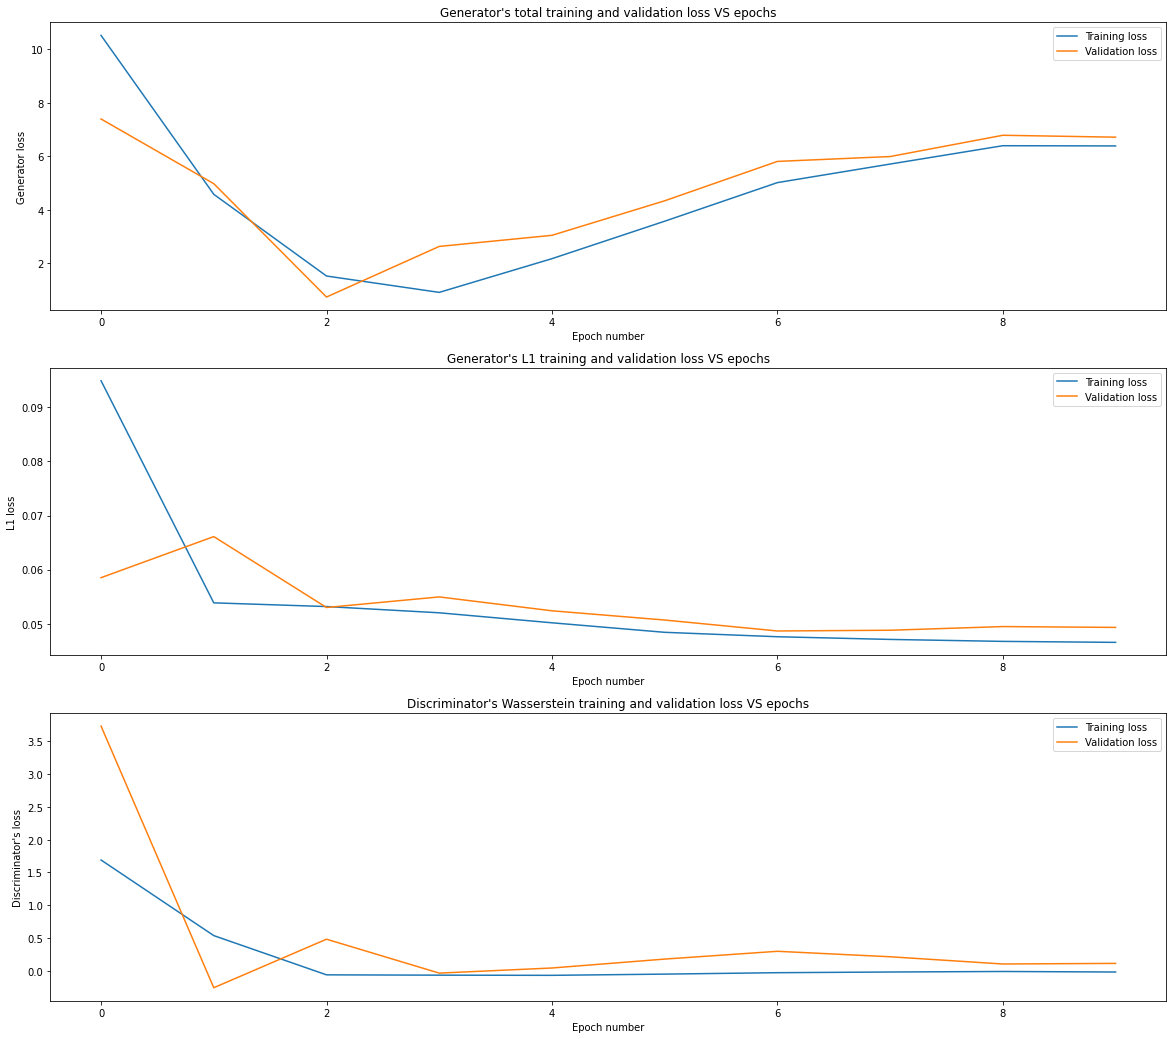

In [19]:
#@markdown ##Play the cell to show the plots of training errors vs. epoch number

logger_path = os.path.join(full_QC_model_path + '/Quality Control/Logger')
all_logger_versions = [os.path.join(logger_path, dname) for dname in os.listdir(logger_path)]
last_logger = all_logger_versions[-1]

train_csv_path = last_logger + '/metrics.csv'

if not os.path.exists(train_csv_path):
  print('The path does not contain a csv file containing the loss and validation evolution of the model')
else:
  with open(train_csv_path,'r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    keys = next(csvRead)
    keys.remove('step')     
    train_metrics = {'g_lr':[], 'd_lr':[],
                    'g_loss_step':[], 'g_l1_step':[],
                    'd_loss_step':[], 'd_wasserstein_step':[], 'd_gp_step':[],
                    'ssim_step':[],
                    'epoch':[],
                    'val_ssim':[], 'val_psnr':[],
                    'val_g_loss':[], 'val_g_l1':[],
                    'val_d_wasserstein':[],
                    'ssim_epoch':[], 
                    'g_loss_epoch':[], 'g_l1_epoch':[],
                    'd_loss_epoch':[], 'd_wasserstein_epoch':[], 'd_gp_epoch':[]
                    }

    for row in csvRead:
      step = int(row[2])
      row.pop(2)
      for i, row_value in enumerate(row):
        if row_value:
          train_metrics[keys[i]].append([step, float(row_value)])


  epochNumber = range(len(train_metrics['g_loss_epoch']))
  plt.figure(figsize=(20,18))

  plt.subplot(3,1,1)
  plt.plot(epochNumber,[e[1] for e in train_metrics['g_loss_epoch']], label='Training loss')
  plt.plot(epochNumber,[e[1] for e in train_metrics['val_g_loss']], label='Validation loss')
  plt.title('Generator\'s total training and validation loss VS epochs')
  plt.ylabel('Generator loss')
  plt.xlabel('Epoch number')
  plt.legend()

  plt.subplot(3,1,2)
  plt.plot(epochNumber,[e[1] for e in train_metrics['g_l1_epoch']], label='Training loss')
  plt.plot(epochNumber,[e[1] for e in train_metrics['val_g_l1']], label='Validation loss')
  plt.title('Generator\'s L1 training and validation loss VS epochs')
  plt.ylabel('L1 loss')
  plt.xlabel('Epoch number')
  plt.legend()

  plt.subplot(3,1,3)
  plt.plot(epochNumber,[e[1] for e in train_metrics['d_wasserstein_epoch']], label='Training loss')
  plt.plot(epochNumber,[e[1] for e in train_metrics['val_d_wasserstein']], label='Validation loss')
  plt.title('Discriminator\'s Wasserstein training and validation loss VS epochs')
  plt.ylabel('Discriminator\'s loss')
  plt.xlabel('Epoch number')
  plt.legend()

  plt.savefig(full_QC_model_path+'/Quality Control/TrainVal_epoch_losses_plots.png')
  plt.show()


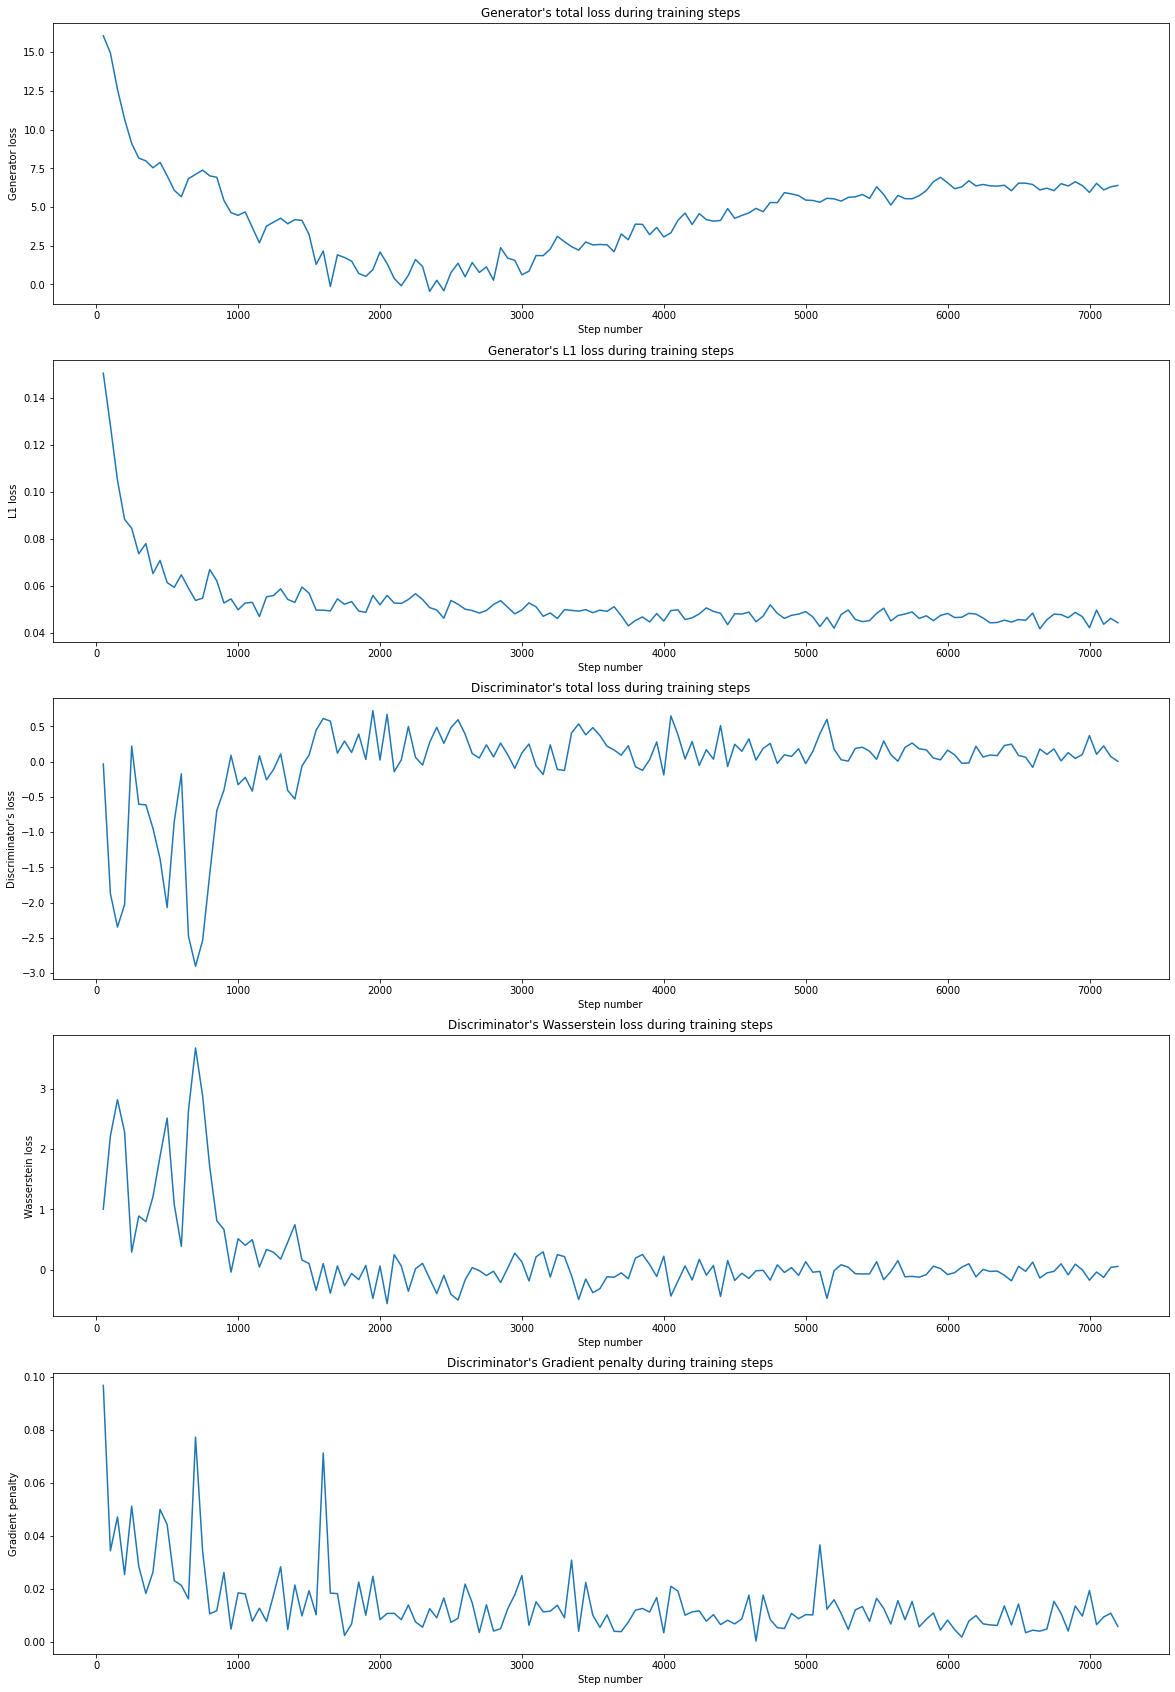

In [20]:
#@markdown ##Play the cell to show the plots of training errors vs. steps number

plt.figure(figsize=(20,30))
  
plt.subplot(5,1,1)
plt.plot([e[0] for e in train_metrics['g_loss_step']], [e[1] for e in train_metrics['g_loss_step']], label='Training loss')
plt.title('Generator\'s total loss during training steps')
plt.ylabel('Generator loss')
plt.xlabel('Step number')

plt.subplot(5,1,2)
plt.plot([e[0] for e in train_metrics['g_l1_step']], [e[1] for e in train_metrics['g_l1_step']], label='Training loss')
plt.title('Generator\'s L1 loss during training steps')
plt.ylabel('L1 loss')
plt.xlabel('Step number')

plt.subplot(5,1,3)
plt.plot([e[0] for e in train_metrics['d_loss_step']], [e[1] for e in train_metrics['d_loss_step']], label='Training loss')
plt.title('Discriminator\'s total loss during training steps')
plt.ylabel('Discriminator\'s loss')
plt.xlabel('Step number')

plt.subplot(5,1,4)
plt.plot([e[0] for e in train_metrics['d_wasserstein_step']], [e[1] for e in train_metrics['d_wasserstein_step']], label='Training loss')
plt.title('Discriminator\'s Wasserstein loss during training steps')
plt.ylabel('Wasserstein loss')
plt.xlabel('Step number')

plt.subplot(5,1,5)
plt.plot([e[0] for e in train_metrics['d_gp_step']], [e[1] for e in train_metrics['d_gp_step']])
plt.title('Discriminator\'s Gradient penalty during training steps')
plt.ylabel('Gradient penalty')
plt.xlabel('Step number')

plt.savefig(full_QC_model_path+'/Quality Control/Train_steps_losses_plots.png')
plt.show()

## **5.2. Image predictions**
---


In [21]:
#@markdown ##Choose the folders that contain your Quality Control dataset
Source_QC_folder = "" #@param{type:"string"}
Target_QC_folder = "" #@param{type:"string"}


#@markdown #####In case you do not have paired LR and HR images, instead of filling the two parameters above completer the ones below: 

Only_high_resolution_data = True #@param {type:"boolean"}
Type_of_data = "Electron microscopy" #@param ["Electron microscopy", "Fluorescence"]
QC_high_resolution_folder = "/content/gdrive/MyDrive/TFM - dataset/test" #@param {type:"string"}


# Create a list of sources

# Insert code to perform predictions on all datasets in the Source_QC folder

model = WGANGP(
    gen_checkpoint = full_QC_model_path + '/best_checkpoint.pth'
)

trainer = Trainer(gpus=1)

dataset = EMDataset(1, 1, Down_factor, transf=ToTensor(), 
                    validation=False, validation_split=0.001, 
                    hr_imgs_basedir=Target_QC_folder, 
                    lr_imgs_basedir=Source_QC_folder,
                    only_high_resolution_data=Only_high_resolution_data, 
                    only_hr_imgs_basedir=QC_high_resolution_folder,
                    type_of_data=Type_of_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
predictions = trainer.predict(model, dataloaders=dataloader)


X_test, Y_test = create_complete_images( Source_QC_folder, Target_QC_folder, 
                                        Only_high_resolution_data, 
                                        Type_of_data, 
                                        QC_high_resolution_folder, 
                                        Down_factor)

X_test = np.expand_dims(X_test, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

if Only_high_resolution_data:
  Source_QC_folder = "/content/LR_images"
  Target_QC_folder = QC_high_resolution_folder

_, test_extension = os.path.splitext(os.listdir(Target_QC_folder)[0])

test_filenames = [x for x in os.listdir( Target_QC_folder ) if x.endswith(test_extension)]
test_filenames.sort()

print( 'Available images : ' + str( len(test_filenames)) )

if Only_high_resolution_data:
  if os.path.exists(Source_QC_folder):
    shutil.rmtree(Source_QC_folder)
  os.makedirs(Source_QC_folder)
  for i, image in enumerate(X_test):
    tf.keras.preprocessing.image.save_img(Source_QC_folder+'/'+test_filenames[i], image, data_format=None, file_format=None)

# #Save the predictions
prediction_QC_folder = os.path.join(full_QC_model_path, 'Quality Control', 'Prediction')
if os.path.exists(prediction_QC_folder):
  shutil.rmtree(prediction_QC_folder)
os.makedirs(prediction_QC_folder)

_MSSSIM_WEIGHTS = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)

psnr_array = []
ssim_array = []
mssim_array = []

for i, pred in enumerate(predictions):
  pred = np.expand_dims(np.squeeze(pred.detach().numpy()),axis=-1)

  tf.keras.preprocessing.image.save_img(prediction_QC_folder+'/'+test_filenames[i], 
                                        pred, data_format=None, file_format=None)

  pred = np.clip( pred, a_min=0, a_max=1 )

  hr_image = Y_test[i]

  psnr_array.append(metrics.peak_signal_noise_ratio(hr_image[:,:,0], pred[:,:,0]))
  ssim_array.append(metrics.structural_similarity(hr_image[:,:,0], pred[:,:,0]))
  mssim_array.append(mssim(hr_image.astype('float32'), pred, max_val=1, 
                            power_factors=_MSSSIM_WEIGHTS, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03))

psnr_mean = np.mean(psnr_array)
ssim_mean = np.mean(ssim_array)
mssim_mean = np.mean(mssim_array)

#del predictions, X_test, Y_test, model, trainer, dataset, dataloader

# ------------- For display ------------
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print("Choose the image file (Once selected, the new set of images will take a few seconds to appear):")
print(" ")
@interact
def show_prediction_results(file = os.listdir(prediction_QC_folder)):
  imageLR = io.imread(os.path.join(Source_QC_folder, file))
  imageHR = io.imread(os.path.join(Target_QC_folder, file))
  imageP = io.imread(os.path.join(prediction_QC_folder, file))

  plt.figure(figsize=(25,25))
  plt.subplot(3, 3, 1)
  plt.imshow( imageLR, 'gray' )
  plt.title( 'Low resolution' )
  # Side by side with its "ground truth"
  plt.subplot(3, 3, 2)
  plt.imshow( imageHR, 'gray' )
  plt.title( 'High resolution' )
  # ant its prediction
  plt.subplot(3, 3, 3)
  plt.imshow( imageP, 'gray' )
  plt.title( 'Prediction' ) 

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Complex discriminator


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Available images : 100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Choose the image file (Once selected, the new set of images will take a few seconds to appear):
 


interactive(children=(Dropdown(description='file', options=('test-input0000.png', 'test-input0001.png', 'test-…

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## **5.3. Error mapping and quality metrics estimation**
---


<font size = 4>This section will calculate the SSIM, PNSR and MSSIM metrics between the predicted and target images to evaluate the quality of the results.

<font size = 4>**1. The SSIM (structural similarity) map** 

<font size = 4>The SSIM metric is used to evaluate whether two images contain the same structures. It is a normalized metric and an SSIM of 1 indicates a perfect similarity between two images. Therefore for SSIM, the closer to 1, the better.
<font size=4>**mSSIM** is the SSIM value calculated across the entire window of both images.

<font size = 4>**2. PSNR (Peak signal-to-noise ratio)** is a metric that gives the difference between the ground truth and prediction (or source input) in decibels, using the peak pixel values of the prediction and the MSE between the images. The higher the score the better the agreement.





In [22]:
#@markdown ##Run to calculate the PSNR, SSIM and MSSIM metrics

print("PSNR: ", psnr_mean)
print("SSIM: ", ssim_mean)
print("MSSIM:", mssim_mean)

PSNR:  24.253714360774893
SSIM:  0.7929630785453979
MSSIM: 0.9283065


<font size = 4>The metrics shown in the previous cell are an average of all the test dataset. In the following cell the metrics refer only to the displayed image. You can see all the metrics for each image in a csv file saved in the Quality Control folder.

In [23]:
#@markdown ##SSIM and RSE map
#@markdown Now we will show the SSIM and RSE maps between the original images (upsampled using simple interpolation) and the target images, together with the maps between the predicted and target images.

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity

def ssim(img1, img2):
  return structural_similarity(img1,img2,data_range=1.,full=True, gaussian_weights=True, use_sample_covariance=False, sigma=1.5)


def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =(x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

def norm_minmse(gt, x, normalize_gt=True):
    """This function is adapted from Martin Weigert"""

    """
    normalizes and affinely scales an image pair such that the MSE is minimized  
     
    Parameters
    ----------
    gt: ndarray
        the ground truth image      
    x: ndarray
        the image that will be affinely scaled 
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled 
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)
    #x = x - np.mean(x)
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)
    #gt = gt - np.mean(gt)
    x_scaled = transform.resize( x, (gt.shape[0], gt.shape[1]), order=1 )
    
    scale = np.cov(x_scaled.flatten(), gt.flatten())[0, 1] / np.var(x_scaled.flatten())
    return gt, scale * x_scaled
    #return gt, x_scaled


# Open and create the csv file that will contain all the QC metrics
with open(full_QC_model_path+"/Quality Control/QC_metrics_"+QC_model_name+".csv", "w", newline='') as file:
    writer = csv.writer(file)

    # Write the header in the csv file
    writer.writerow(["image #","Prediction v. GT mSSIM","Input v. GT mSSIM", "Prediction v. GT NRMSE", "Input v. GT NRMSE", "Prediction v. GT PSNR", "Input v. GT PSNR"])  

    # Let's loop through the provided dataset in the QC folders
    print('Computing maps...')

    for i in os.listdir(Target_QC_folder):
      if not os.path.isdir(os.path.join(Source_QC_folder,i)):
        
        _, image_extension = os.path.splitext(i)
        #print('Running QC on: '+i)
      # -------------------------------- Target test data (Ground truth) --------------------------------
        test_GT = io.imread(os.path.join(Target_QC_folder, i))
        #test_GT = test_patches_gt

      # -------------------------------- Source test data --------------------------------
        test_source = io.imread(os.path.join(Source_QC_folder,i))
        #test_source = test_patches_wf

      # Normalize the images wrt each other by minimizing the MSE between GT and Source image
        test_GT_norm,test_source_norm = norm_minmse(test_GT, test_source, normalize_gt=True)

      # -------------------------------- Prediction --------------------------------
        test_prediction = io.imread(os.path.join(prediction_QC_folder,i))

      # Normalize the images wrt each other by minimizing the MSE between GT and prediction
        test_GT_norm,test_prediction_norm = norm_minmse(test_GT, test_prediction, normalize_gt=True)        

      # -------------------------------- Calculate the metric maps and save them --------------------------------

      # Calculate the SSIM maps
        index_SSIM_GTvsPrediction, img_SSIM_GTvsPrediction = ssim(test_GT_norm, test_prediction_norm)
        index_SSIM_GTvsSource, img_SSIM_GTvsSource = ssim(test_GT_norm, test_source_norm)

      #Save ssim_maps
        img_SSIM_GTvsPrediction_32bit = np.float32(img_SSIM_GTvsPrediction)
        img_SSIM_GTvsSource_32bit = np.float32(img_SSIM_GTvsSource)
        if image_extension == '.tif':
          io.imsave(full_QC_model_path+'/Quality Control/SSIM_GTvsPrediction_'+i, img_SSIM_GTvsPrediction_32bit)
          io.imsave(full_QC_model_path+'/Quality Control/SSIM_GTvsSource_'+i, img_SSIM_GTvsSource_32bit)
        else:
          io.imsave(full_QC_model_path+'/Quality Control/SSIM_GTvsPrediction_'+i, img_as_uint(img_SSIM_GTvsPrediction_32bit))
          io.imsave(full_QC_model_path+'/Quality Control/SSIM_GTvsSource_'+i, img_as_uint(img_SSIM_GTvsSource_32bit))
            
      # Calculate the Root Squared Error (RSE) maps
        img_RSE_GTvsPrediction = np.sqrt(np.square(test_GT_norm - test_prediction_norm))
        img_RSE_GTvsSource = np.sqrt(np.square(test_GT_norm - test_source_norm))

      # Save SE maps
        img_RSE_GTvsPrediction_32bit = np.float32(img_RSE_GTvsPrediction)
        img_RSE_GTvsSource_32bit = np.float32(img_RSE_GTvsSource)
        if image_extension == '.tif':
          io.imsave(full_QC_model_path+'/Quality Control/RSE_GTvsPrediction_'+i, np.clip(img_RSE_GTvsPrediction_32bit, -1, 1))
          io.imsave(full_QC_model_path+'/Quality Control/RSE_GTvsSource_'+i, np.clip(img_RSE_GTvsSource_32bit, -1, 1))
        else:
          io.imsave(full_QC_model_path+'/Quality Control/RSE_GTvsPrediction_'+i, img_as_uint(np.clip(img_RSE_GTvsPrediction_32bit, -1, 1)))
          io.imsave(full_QC_model_path+'/Quality Control/RSE_GTvsSource_'+i, img_as_uint(np.clip(img_RSE_GTvsSource_32bit, -1, 1)))


      # -------------------------------- Calculate the RSE metrics and save them --------------------------------

      # Normalised Root Mean Squared Error (here it's valid to take the mean of the image)
        NRMSE_GTvsPrediction = np.sqrt(np.mean(img_RSE_GTvsPrediction))
        NRMSE_GTvsSource = np.sqrt(np.mean(img_RSE_GTvsSource))
        
      # We can also measure the peak signal to noise ratio between the images
        PSNR_GTvsPrediction = psnr(test_GT_norm,test_prediction_norm,data_range=1.0)
        PSNR_GTvsSource = psnr(test_GT_norm,test_source_norm,data_range=1.0)

        writer.writerow([i,str(index_SSIM_GTvsPrediction),str(index_SSIM_GTvsSource),str(NRMSE_GTvsPrediction),str(NRMSE_GTvsSource),
                         str(PSNR_GTvsPrediction),str(PSNR_GTvsSource)])

# All data is now processed saved
Test_FileList = os.listdir(prediction_QC_folder) # this assumes, as it should, that both source and target are named the same


plt.figure(figsize=(15,15))
# Currently only displays the last computed set, from memory

df = pd.read_csv(full_QC_model_path+"/Quality Control/QC_metrics_"+QC_model_name+".csv")

# ------------- For display ------------
print('------------------------------------------------------------------------------------------------------------------------')
print("Choose the image file (once selected, the new set of images will take a few seconds to appear):")
print(" ")
@interact
def show_QC_results(file = sorted(os.listdir(Source_QC_folder))):
  visualise_image_comparison_QC(image = file, dimension='2D', Source_folder=Source_QC_folder , 
                                Prediction_folder= prediction_QC_folder, 
                                Ground_truth_folder=Target_QC_folder, 
                                QC_folder=full_QC_model_path+"/Quality Control", 
                                QC_scores= df )  

print('------------------------------------------------------------------------------------------------------------------------')

Computing maps...
------------------------------------------------------------------------------------------------------------------------
Choose the image file (once selected, the new set of images will take a few seconds to appear):
 


<Figure size 1080x1080 with 0 Axes>

interactive(children=(Dropdown(description='file', options=('test-input0000.png', 'test-input0001.png', 'test-…

------------------------------------------------------------------------------------------------------------------------


# **6. Using the trained model**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.

## **6.1. Generate prediction(s) from unseen dataset**
---
<font size = 4>The current trained model (from section 4.2) can now be used to process images. If you want to use an older model, untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Result_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output images.

In [24]:
#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Data_folder = "/content/gdrive/MyDrive/TFM - dataset/test" #@param {type:"string"}
Result_folder = "/content/Untitled Folder" #@param {type:"string"}


#@markdown ###Does **Data_folder** contain *High resolution* images?
#@markdown ##### If your data only contains *High resolution* images, check the option below. The *Low resolution* images will be generated from the *High resolution* data given in the **Data_foder**.    

Are_high_resolution_images = True #@param {type:"boolean"}

Type_of_data = "Electron microscopy" #@param ["Electron microscopy", "Fluorescence"]


# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, provide the name of the model and path to model folder:
#@markdown #####During training, the model files are automatically saved inside a folder named after model_name in section 3. Provide the path to this folder below.
Prediction_model_folder = "/content/gdrive/MyDrive/WGAN/WGAN" #@param {type:"string"}
Prediction_down_factor = 2 #@param {type:"number"}


if not os.path.exists(Result_folder):
  print("The "+Result_folder+ " path does not exist")
  os.makedirs(Result_folder)

#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)

if (Use_the_current_trained_model): 
  print("Using current trained network")
  Prediction_model_name = Model_name
  Prediction_model_path = Model_path
else:
  Down_factor = Prediction_down_factor

full_Prediction_model_path = os.path.join(Prediction_model_path, Prediction_model_name)
if os.path.exists(full_Prediction_model_path):
  print("The "+Prediction_model_name+" network will be used.")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

# Read the list of file names

#Save the predictions
prediction_QC_folder = os.path.join(Result_folder, 'Quality Control', 'Prediction')
if os.path.exists(Result_folder):
  shutil.rmtree(Result_folder)
os.makedirs(Result_folder)

_, extension = os.path.splitext(os.listdir(Data_folder)[0])

filenames = [x for x in os.listdir( Data_folder ) if x.endswith(extension)]
filenames.sort()
print( 'Available images: ' + str( len(filenames)) )

model = WGANGP(
    gen_checkpoint = full_Prediction_model_path + '/best_checkpoint.pth'
)

trainer = Trainer(gpus=1)

dataset = EMDataset(1, 1, Down_factor, transf=ToTensor(), 
                    validation=False, validation_split=0.001, 
                    hr_imgs_basedir=Data_folder, 
                    lr_imgs_basedir=Data_folder,
                    only_high_resolution_data=Are_high_resolution_images, 
                    only_hr_imgs_basedir=Data_folder,
                    type_of_data=Type_of_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
predictions = trainer.predict(model, dataloaders=dataloader)

for i, pred in enumerate(predictions):
  pred = np.expand_dims(np.squeeze(pred.detach().numpy()),axis=-1)
  tf.keras.preprocessing.image.save_img(Result_folder+'/'+filenames[i], pred)

print("Images saved into folder:", Result_folder)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using current trained network
The WGAN network will be used.
Available images: 100
Complex discriminator


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Images saved into folder: /content/Untitled Folder


## **6.2. Inspect the predicted output**
---



In [17]:
# @markdown  ##Run this cell to see some inputs with their corresponding outputs
##Run this cell to display a randomly chosen input and its corresponding predicted output.

# ------------- For display ------------
print('---------------------------------------------------------------------------------------------------------------------------------------------------')
print("Choose the image file (Once selected, the new set of images will take a few seconds to appear):")
print(" ")
@interact
def show_prediction_results(file = sorted(os.listdir(Data_folder))):
  imageLR = io.imread(os.path.join(Data_folder, file))
  imageP = io.imread(os.path.join(Result_folder, file))

  plt.figure(figsize=(25,25))
  plt.subplot(3, 3, 1)
  plt.imshow( imageLR, 'gray' )
  plt.title( 'Low resolution' )
  # ant its prediction
  plt.subplot(3, 3, 2)
  plt.imshow( imageP, 'gray' )
  plt.title( 'Prediction' ) 

print('---------------------------------------------------------------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------------------------------------------------------------
Choose the image file (Once selected, the new set of images will take a few seconds to appear):
 


interactive(children=(Dropdown(description='file', options=('test-input0000.png', 'test-input0001.png', 'test-…

---------------------------------------------------------------------------------------------------------------------------------------------------


## **6.3. Download your predictions**
---

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that the notebook will otherwise **OVERWRITE** all files which have the same name.

# **7. Version log**
---




#**Thank you for using WGAN!**